<a href="https://colab.research.google.com/github/Amiya-Kalita/Machine-Learning/blob/main/3_AdaBoost_Machine_Learningipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
from string import ascii_uppercase
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import roc_auc_score , roc_curve , accuracy_score , confusion_matrix , classification_report
from sklearn.preprocessing import OneHotEncoder , StandardScaler , minmax_scale
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree

In [6]:
adult_df = pd.read_csv("/content/drive/MyDrive/DataSets/adult.csv")

In [9]:
adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [7]:
adult_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [8]:
adult_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [10]:
# we need to replace the income with an integer that denoted its class
adult_df['income'] = np.where(adult_df['income'] == '>50K' , 1 , 0)

In [13]:
def hist_chart(df, column):
    x , y = [], []
    for value in sorted(df[column].unique()):
        x.append(value)
        y.append(df[df[column] == value]['income'].mean()* 100.0)
    index = np.arange(len(x))
    width = 0.35
    plt.bar(index, y, width)
    plt.xticks(index+width/2, x, rotation=70)
    plt.yticks(np.arange(0, 100, 10))
    plt.ylim(0, 100)
    plt.xlabel(column)
    plt.ylabel('Percentage of people who\'s income is above $50K')
    plt.tight_layout()
    plt.show()

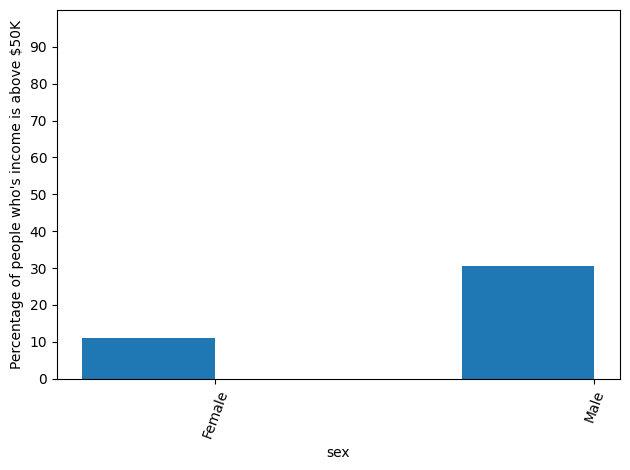

In [14]:
hist_chart(adult_df , 'sex')

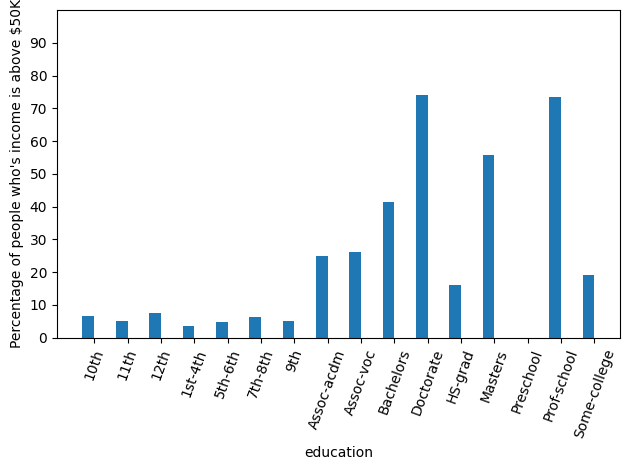

In [15]:
hist_chart(adult_df, 'education')

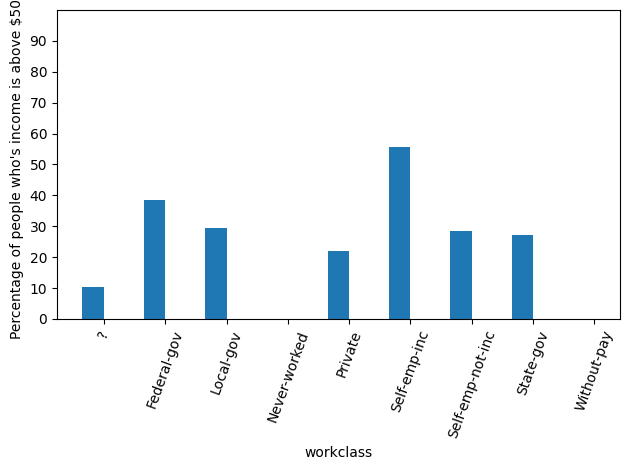

In [17]:
hist_chart(adult_df , 'workclass')

In [18]:
# Get rid of the entries where the occupation or workclass is unknown
adult_df = adult_df[adult_df['occupation'] != '?']
adult_df = adult_df[adult_df['workclass'] != '?']

In [19]:
# Get the dummies for the columns. This is the same as LabelBinarizer in sklearn
education_dummies = pd.get_dummies(adult_df['education'])
marital_dummies = pd.get_dummies(adult_df['marital.status'])
relationship_dummies = pd.get_dummies(adult_df['relationship'])
sex_dummies = pd.get_dummies(adult_df['sex'])
occupation_dummies = pd.get_dummies(adult_df['occupation'])
native_dummies = pd.get_dummies(adult_df['native.country'])
race_dummies = pd.get_dummies(adult_df['race'])
workclass_dummies = pd.get_dummies(adult_df['workclass'])

In [20]:
# Example: for marital status
marital_dummies.head()

,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
1,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False
4,False,False,False,False,False,True,False
5,True,False,False,False,False,False,False
6,False,False,False,False,False,True,False


In [23]:
# Define a function to put the continuous values in bins
def into_bins(column, bins):
    group_names = list(ascii_uppercase[:len(bins)-1])
    binned = pd.cut(column, bins, labels=group_names)
    return binned

In [24]:
adult_df['capital.loss'].describe()

,capital.loss
count,30718.000000
mean,88.910216
std,405.657203
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4356.000000


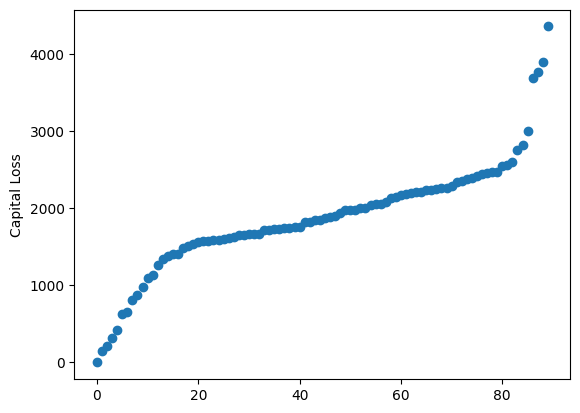

In [25]:
unique = sorted(adult_df['capital.loss'].unique())
plt.scatter(range(len(unique)), unique)
plt.ylabel('Capital Loss')
plt.tick_params(axis='x', which='both', labelbottom='off', bottom='off') # disable x ticks
plt.show()

In [26]:
loss_bins = into_bins(adult_df['capital.loss'], list(range(-1, 4500, 500)))
loss_dummies = pd.get_dummies(loss_bins)

In [27]:
adult_df['capital.gain'].describe()

,capital.gain
count,30718.000000
mean,1106.037079
std,7497.863364
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,99999.000000


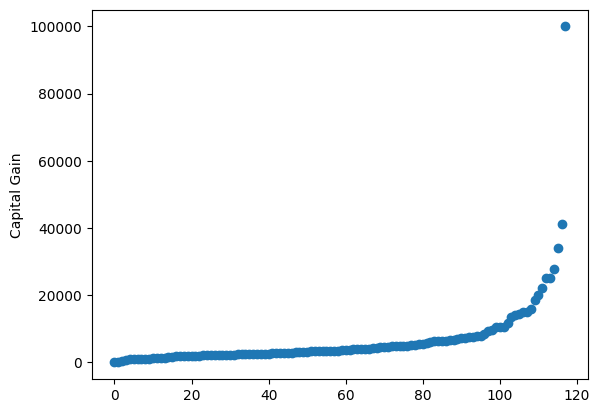

In [28]:
unique = sorted(adult_df['capital.gain'].unique())
plt.scatter(range(len(unique)), unique)
plt.ylabel('Capital Gain')
plt.tick_params(axis='x', which='both', labelbottom='off', bottom='off') # disable x ticks
plt.show()

In [29]:
gain_bins = into_bins(adult_df['capital.gain'], list(range(-1, 42000, 5000)) + [100000])
gain_dummies = pd.get_dummies(gain_bins)

In [30]:
X = pd.concat([adult_df[['age', 'hours.per.week']], gain_dummies, occupation_dummies, workclass_dummies, education_dummies, marital_dummies, race_dummies, sex_dummies], axis=1)
y = adult_df['income']

# Create test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=1)

In [31]:
clf = AdaBoostClassifier(random_state=1)
clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

In [32]:
y_pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Accuracy: 0.8317057291666666
